In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 16.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *

train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
# test_sampled_all = glob.glob('./drive/MyDrive/compsci/test_sampled_all_centered_220.csv')
test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)
    
# for j in test_all:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [4]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [5]:
# X_train1 = X_train.reshape(X_train.shape + (1,1))
# X_test1 = X_test.reshape(X_test.shape + (1,1))

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)

In [6]:
class_num = 1

N_train = train_values
N_test = test_values[test_values[:,-2]==class_num]

X_train = N_train[:,:-2]
X_test = N_test[:,:-2]

y_train = N_train[:len(N_train),-2]
y_test = N_test[:len(N_test),-2]

# y_train = train_values[:len(N_train),-2]
# y_test = test_values[:len(N_test),-2]

X_train1 = X_train.reshape(X_train.shape + (1,1,))
X_test1 = X_test.reshape(X_test.shape + (1,1,))

y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

In [7]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)
    return cm

In [8]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 256
activationFunction='relu'

def getlstmModel():
    
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train1.shape[1],1)))
    lstmmodel.add(LSTM(9, return_sequences=True))
    lstmmodel.add(MaxPooling1D(pool_size=2))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(512, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 220, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 220, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 9)            0         
_________________________________________________________________
flatten (Flatten)            (None, 990)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               507392    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [9]:
lstmmodelhistory= lstmmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25529/25529 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.8061

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 35s 1ms/sample - loss: 0.5945 - accuracy: 0.8061 - val_loss: 0.2239 - val_accuracy: 0.9337
Epoch 2/5
25529/25529 [==============================] - 28s 1ms/sample - loss: 0.1834 - accuracy: 0.9427 - val_loss: 0.1640 - val_accuracy: 0.9464
Epoch 3/5
25529/25529 [==============================] - 28s 1ms/sample - loss: 0.1302 - accuracy: 0.9601 - val_loss: 0.1251 - val_accuracy: 0.9618
Epoch 4/5
25529/25529 [==============================] - 28s 1ms/sample - loss: 0.0893 - accuracy: 0.9715 - val_loss: 0.1100 - val_accuracy: 0.9622
Epoch 5/5
25529/25529 [==============================] - 28s 1ms/sample - loss: 0.0748 - accuracy: 0.9758 - val_loss: 0.1018 - val_accuracy: 0.9671


In [10]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[1].output])
last_lstm_lstm = get_last_lstm([X_test1[:,:,:,0]])[0]

get_softmax1_lstm = keras.backend.function([lstmmodel.layers[0].input, keras.backend.learning_phase()], [lstmmodel.layers[-1].output])
softmax1_lstm = get_softmax1_lstm(([X_test1[:,:,:,0]]))[0]
softmax_weight1_lstm = lstmmodel.get_weights()[-1]
softmax_weight_lstm = np.reshape(softmax_weight1_lstm,(9,1))

CAM = np.dot(last_lstm_lstm, softmax_weight_lstm)

# for k in range(5):
#     CAM_lstm = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
#     c = np.exp(CAM_lstm) / np.sum(np.exp(CAM_lstm), axis=1, keepdims=True)
#     plt.figure(figsize=(18, 4))
#     plt.plot(X_test1[k].squeeze())
#     plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
#     # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_lstm[k][int(y_test[k])]))
#     plt.clim(0.003,0.010)
#     plt.colorbar()
# plt.show

In [11]:
lstmpredictions = lstmmodel.predict(X_test1[:,:,:,0], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy  : 0.9410862975995541
Precision : 1.0
f1Score : 0.9696491070627299
[[27012    75    14   296   534   715    55     2]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0]]
              precision    recall  f1-score   support

           1      1.000     0.941     0.970     28703
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0

    accuracy               

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


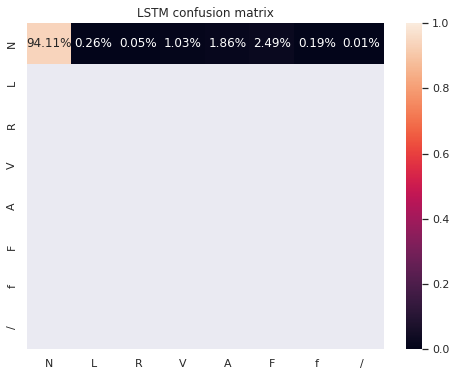

In [12]:
# performance metrics

lstm_predict=np.argmax(lstmpredictions,axis=1)
lstm_actual_value=np.argmax(y_test1,axis=1)
lstm_cf_m = showResults(lstm_actual_value, lstm_predict)
from sklearn import metrics
lstmmetrics = metrics.classification_report(lstm_actual_value, lstm_predict, digits=3)
print(lstmmetrics, 'lstm metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
lstm_cf_m = lstm_cf_m.astype('float')/ lstm_cf_m.sum(axis=1)[:,np.newaxis]
sns.heatmap(lstm_cf_m,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('LSTM confusion matrix')
plt.show()

In [13]:
from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_lstm_lstm
new_last_lstm = []
for i in range(len(last_lstm_lstm)):
  means = list(means_of_slices(a[i], 20))
  new_last_lstm.append(means)
new_last_lstm = np.array(new_last_lstm)
print(new_last_lstm.shape)

final_last_lstm = []
for i in new_last_lstm:
  final_last_lstm.append(np.repeat(i,20))
final_last_lstm = np.array(final_last_lstm)
print(final_last_lstm.shape)

(28703, 11)
(28703, 220)


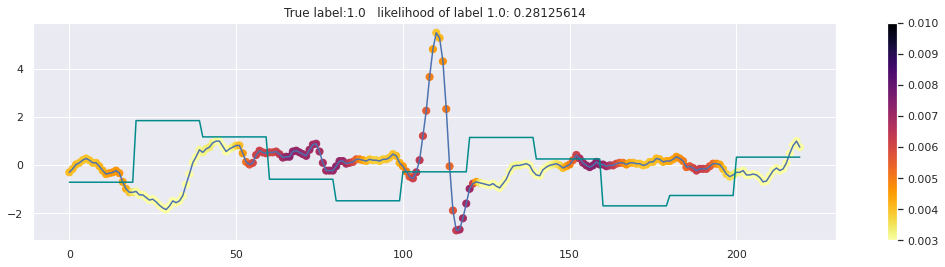

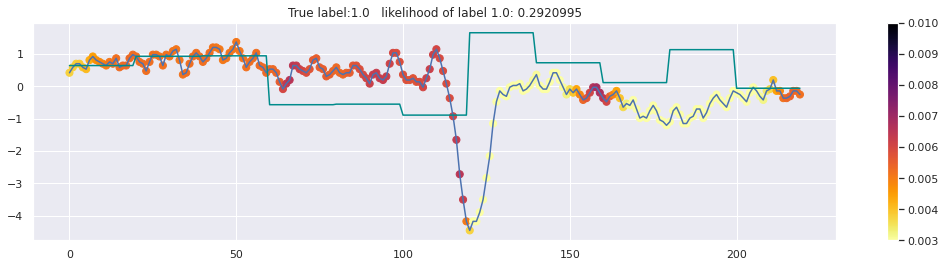

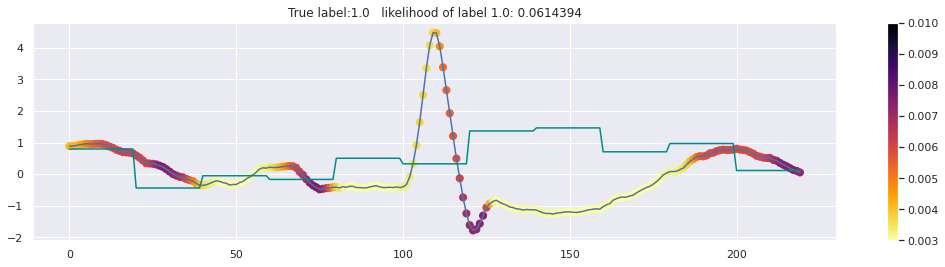

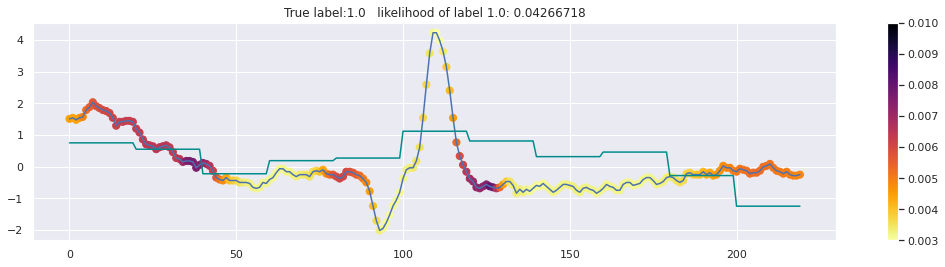

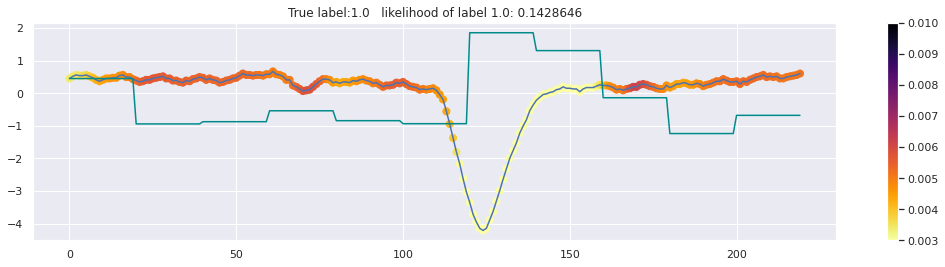

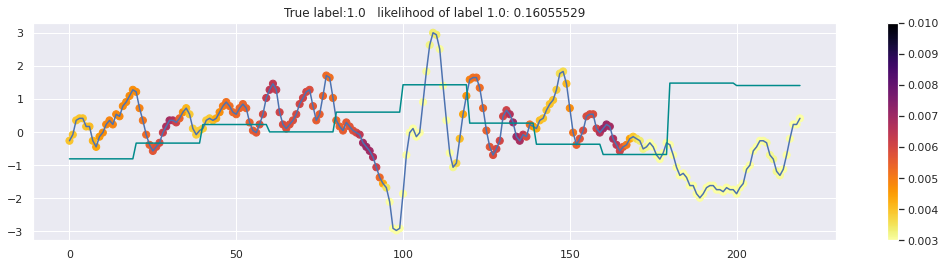

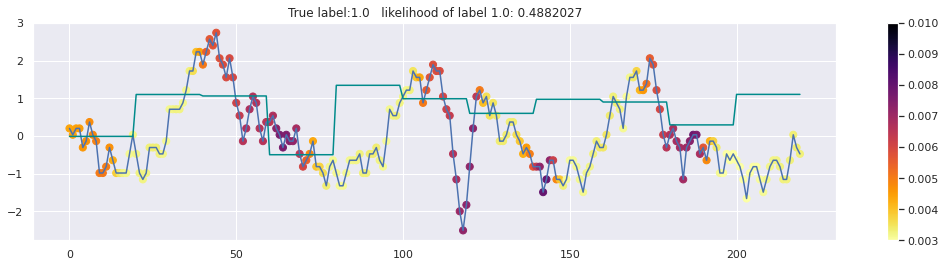

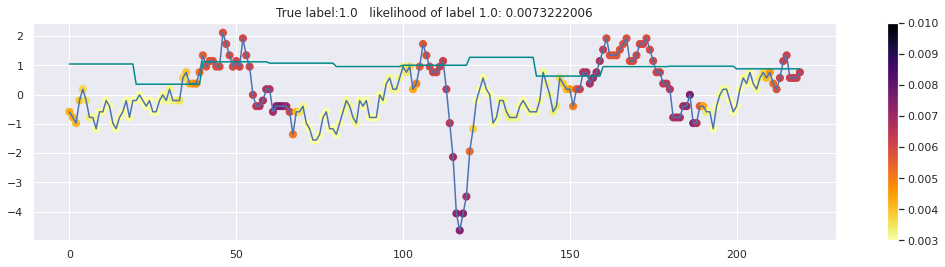

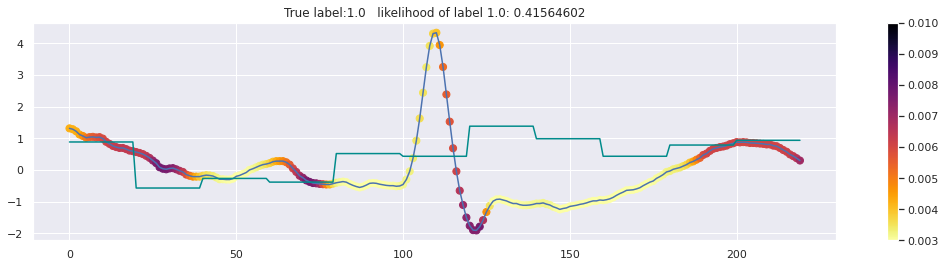

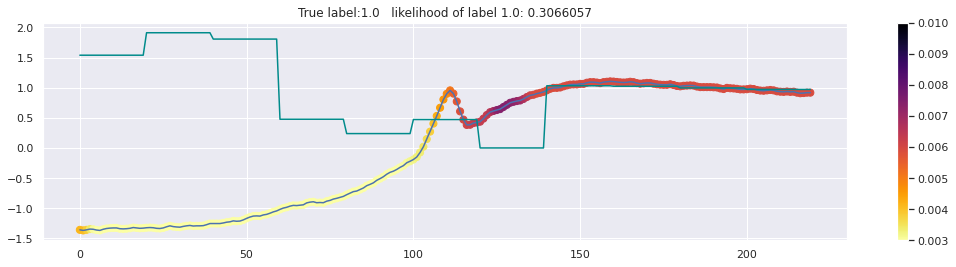

In [14]:
#misclassified saliency
misclass_lstm = np.where(lstm_predict!=lstm_actual_value)
misclass_lstm = misclass_lstm[0].tolist()

for i in misclass_lstm[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

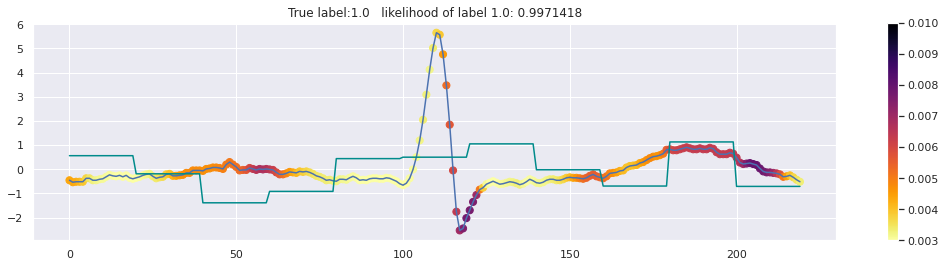

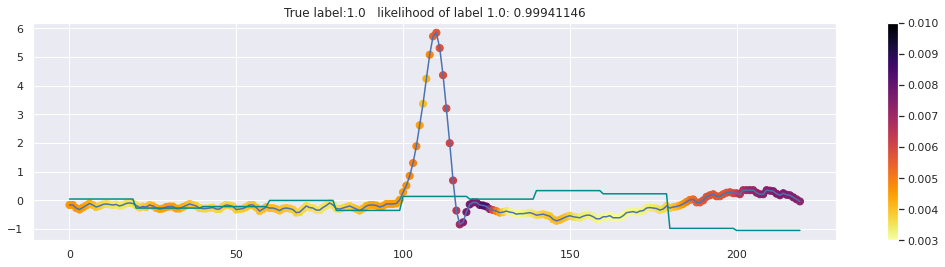

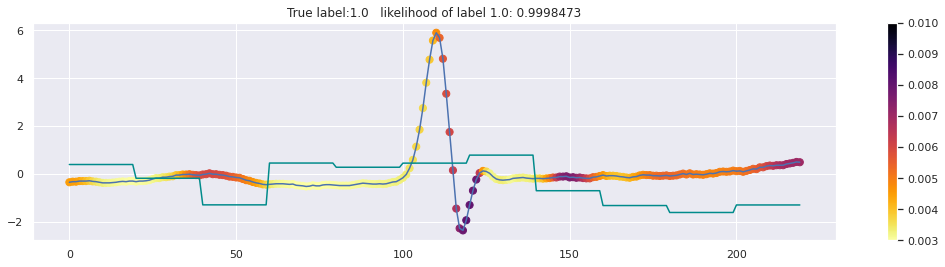

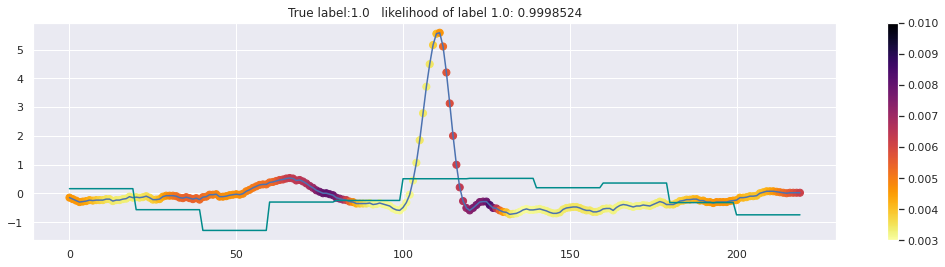

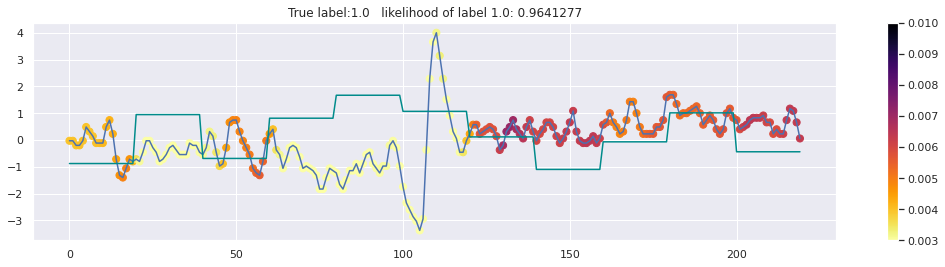

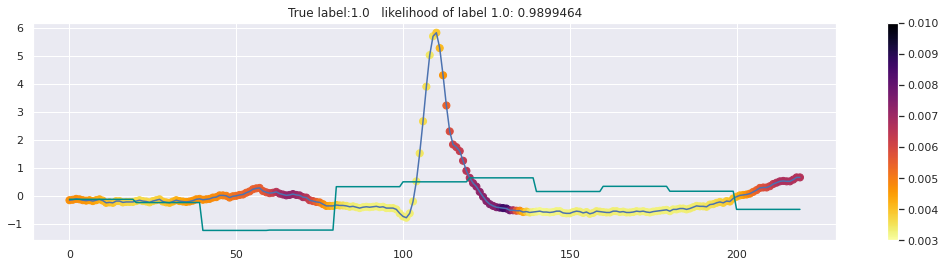

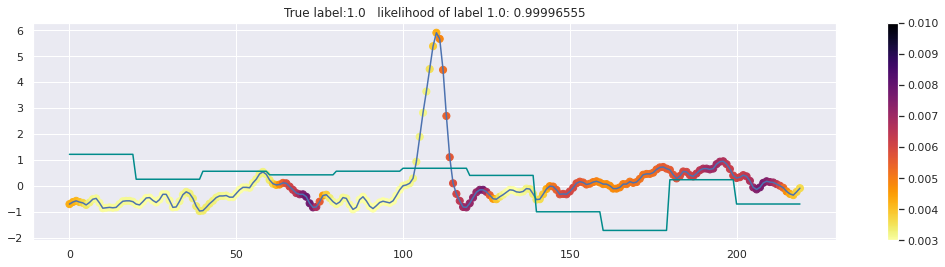

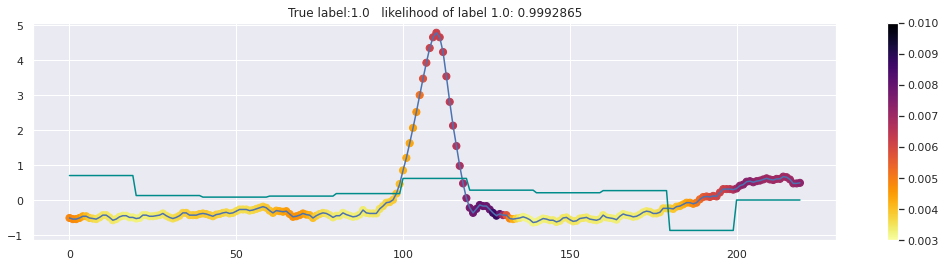

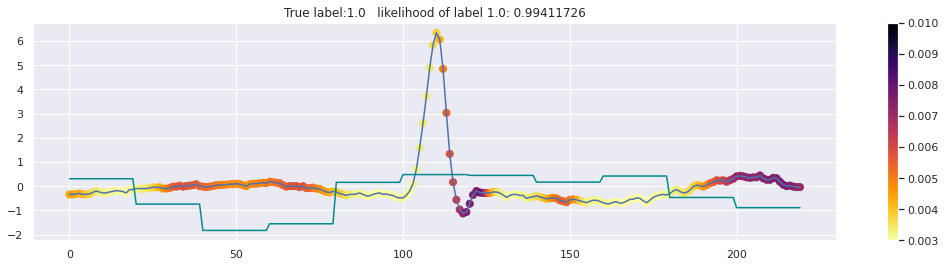

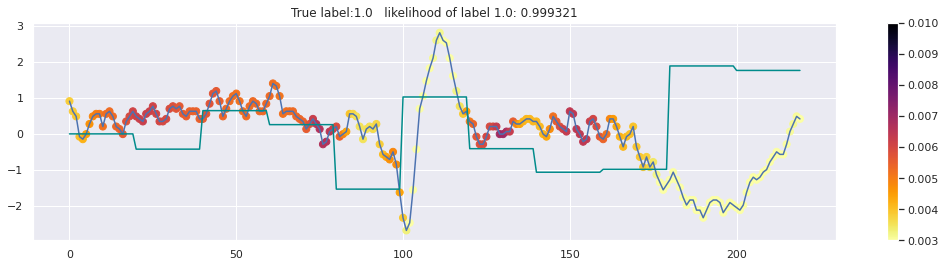

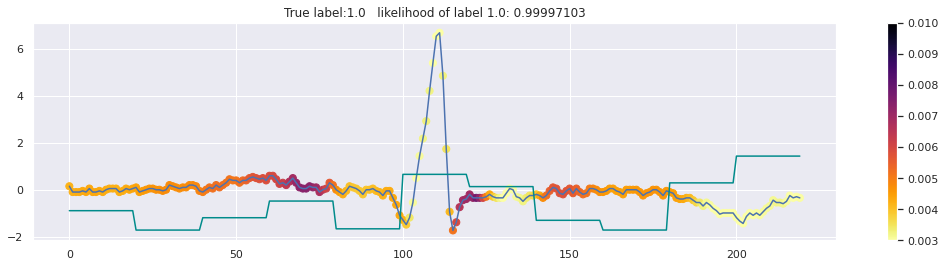

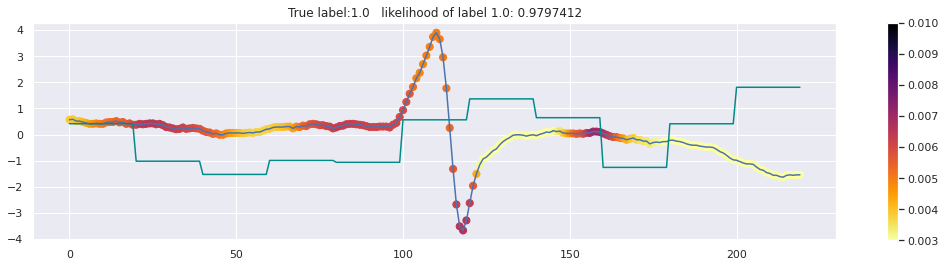

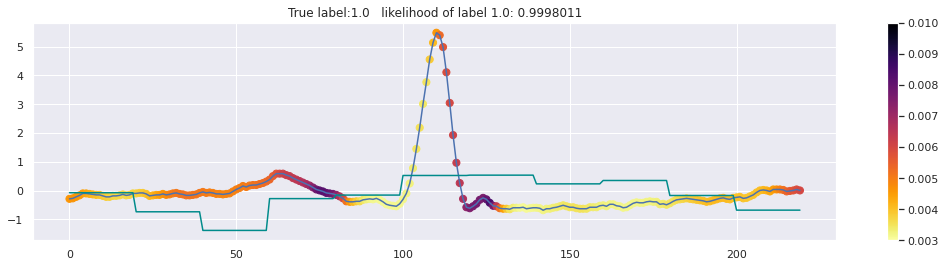

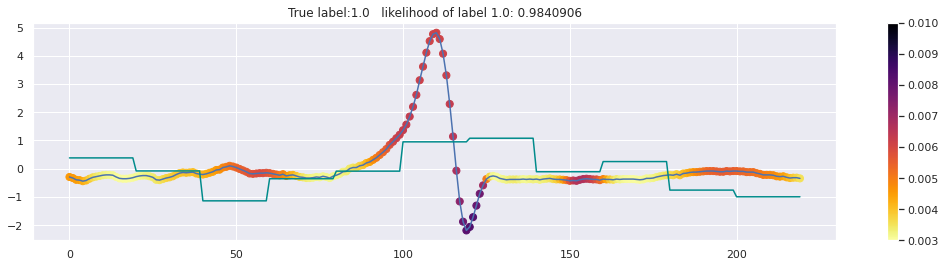

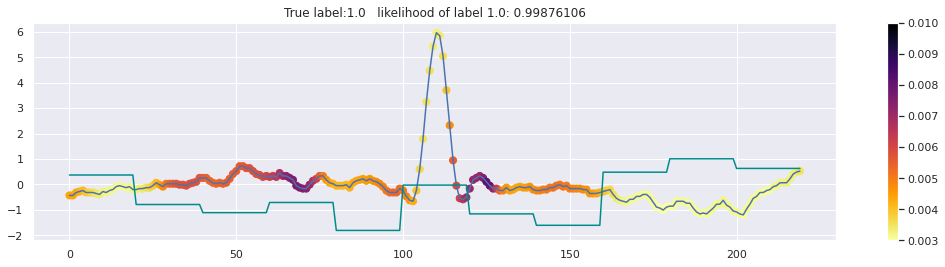

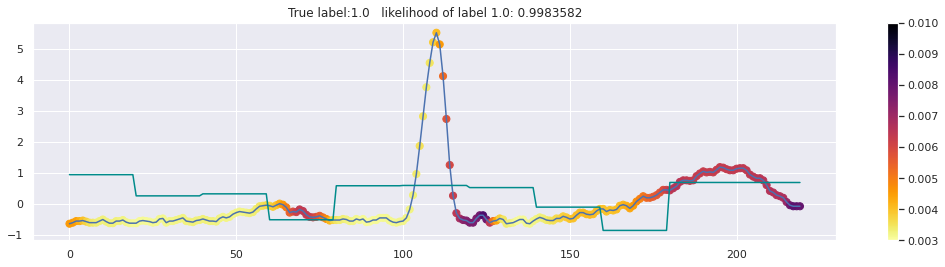

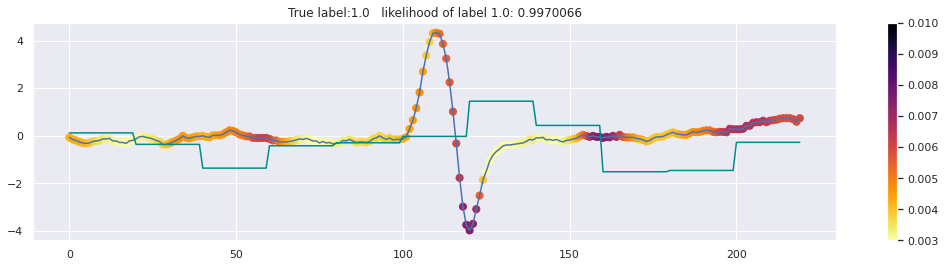

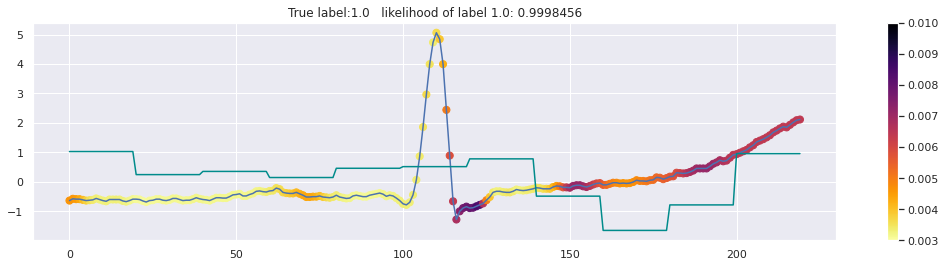

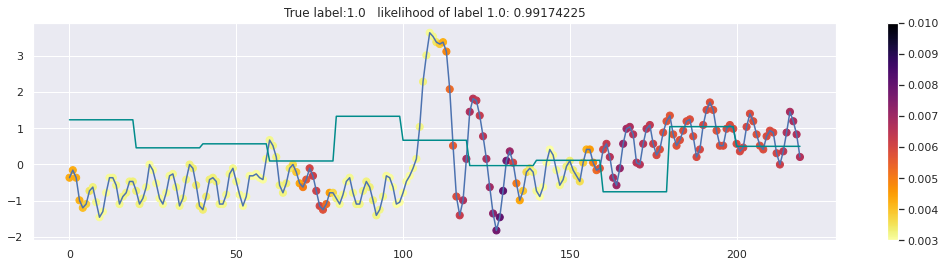

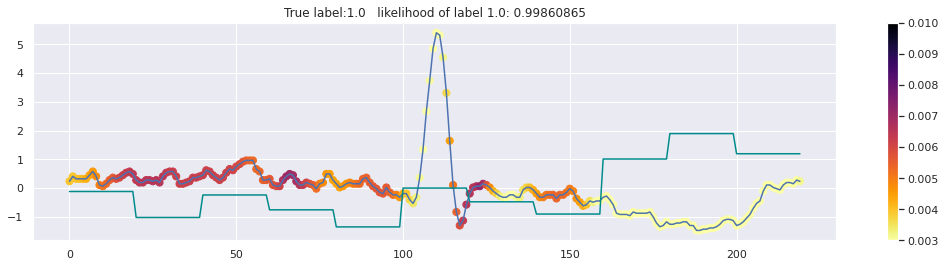

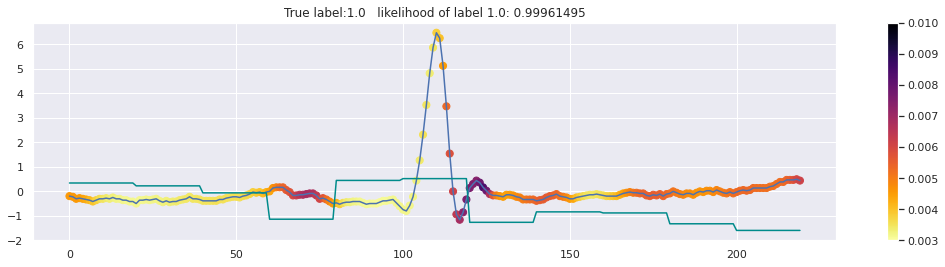

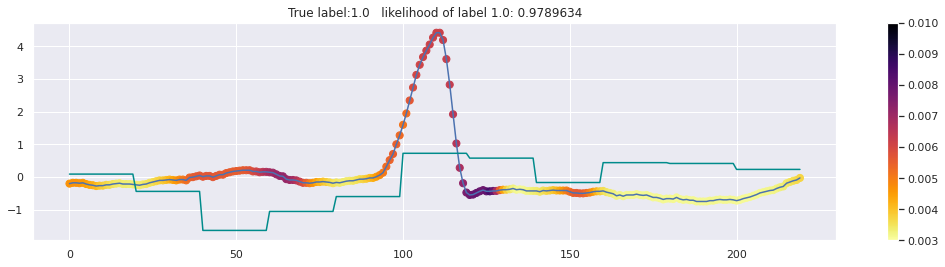

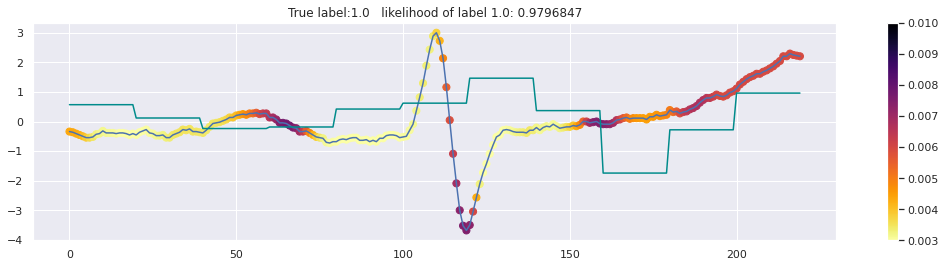

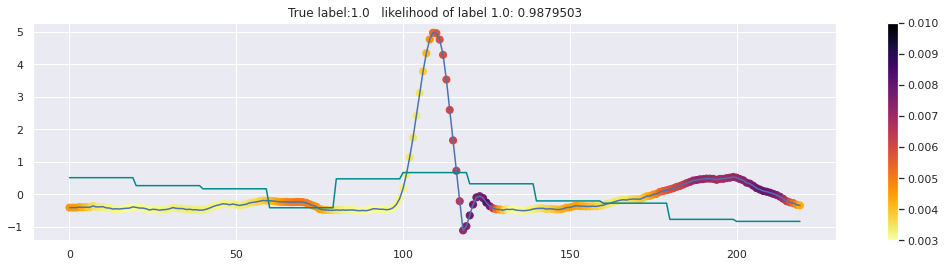

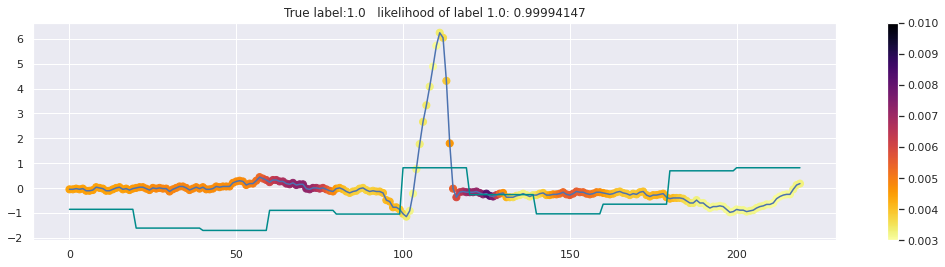

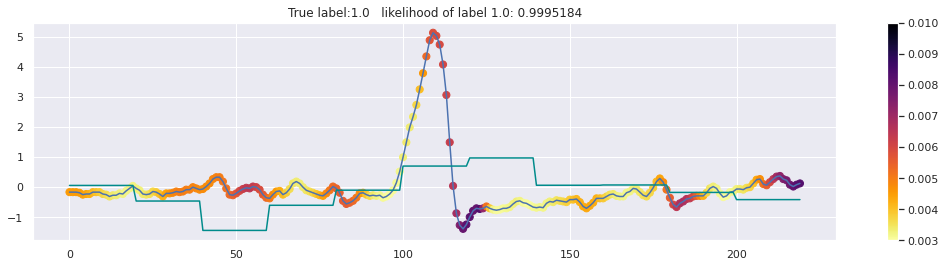

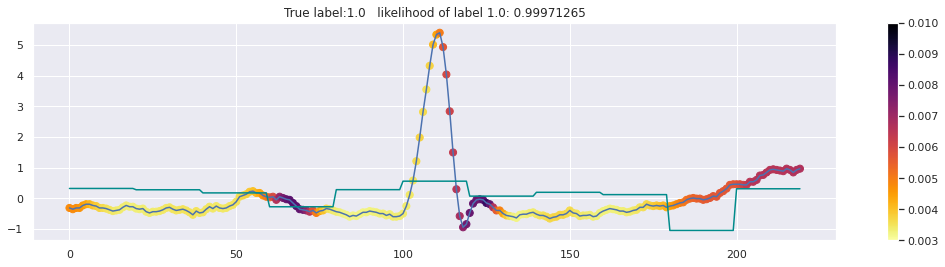

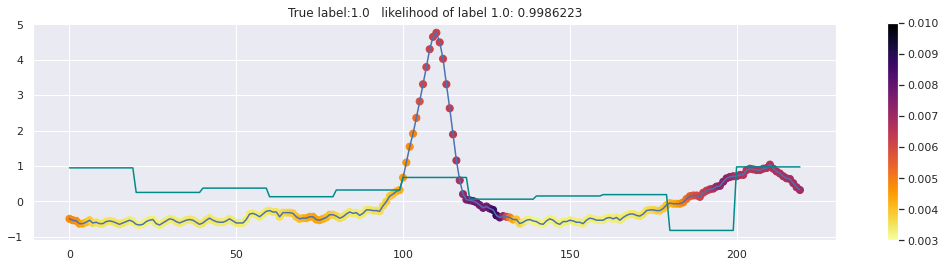

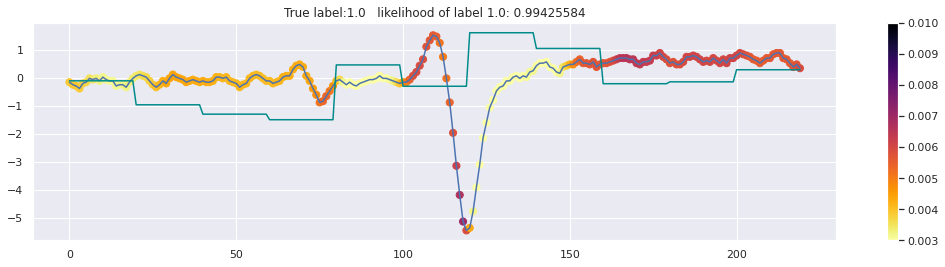

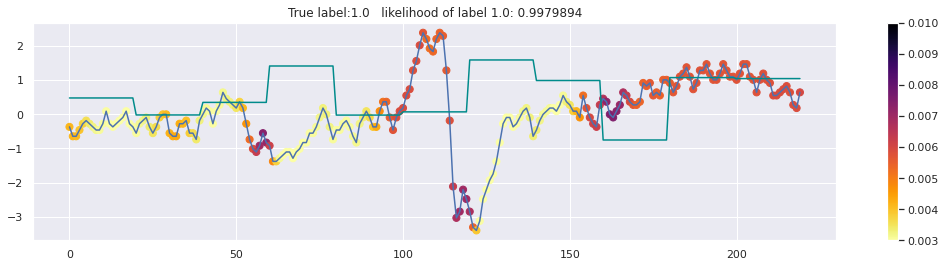

In [15]:
#correct saliency
correct_lstm = np.where(lstm_predict==lstm_actual_value)
correct_lstm = correct_lstm[0].tolist()

for i in correct_lstm[:30]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_lstm[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_lstm[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

In [16]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier

NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
NNMLP_clf.fit(new_last_lstm, y_test1[:])
perm = PermutationImportance(NNMLP_clf).fit(new_last_lstm, y_test1[:])
print('LSTM result')
eli5.show_weights(perm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


LSTM result


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


In [17]:
perm = PermutationImportance(NNMLP_clf).fit(new_last_lstm[correct_lstm[:]], y_test1[[correct_lstm[:]]])
print('LSTM Correct results')
eli5.show_weights(perm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


LSTM Correct results


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


In [18]:
perm = PermutationImportance(NNMLP_clf).fit(new_last_lstm[misclass_lstm[:]], y_test1[misclass_lstm[:]])
print('LSTM Misclass results')
eli5.show_weights(perm)

LSTM Misclass results


/usr/local/lib/python3.7/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,x10
0 ± 0.0000,x9
0 ± 0.0000,x8
0 ± 0.0000,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4
0 ± 0.0000,x3
0 ± 0.0000,x2
0 ± 0.0000,x1


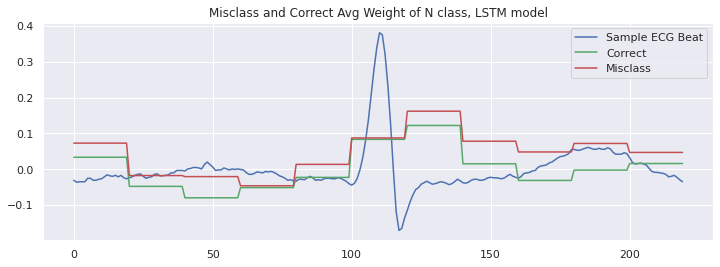

In [19]:
from sklearn.preprocessing import normalize

n0= normalize(final_last_lstm[correct_lstm[:]])
n1= normalize(final_last_lstm[misclass_lstm[:]])
n2= normalize(X_test)

m0=n0.mean(axis=0)
m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='Sample ECG Beat')
plt.plot(m0*2,color='g',label='Correct')
plt.plot(m1*2,color='r',label='Misclass')
plt.title('Class: N, Number: ' + str(class_num))
plt.title('Misclass and Correct Avg Weight of N class, LSTM model')
# plt.title('Misclass and Correct Avg Weight of all beats, LSTM model')
plt.legend()
plt.show()

In [20]:
# # saving the model

# model_json = lstmmodel.to_json()
# with open("NEWlstmmodel_testunsam.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# lstmmodel.save_weights("NEWlstmmodel_testunsam_weights.h5")
# lstmmodel.save("NEWlstmmodel_testunsam.h5")
# print("Saved model to disk")